<a href="https://colab.research.google.com/github/elizabethyoo/team_9/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis

## autoregression for univariate TS 1-step lookahead forecasting 

## ARIMA for multivariate TS 1-step lookahead forecasting 

In [62]:
# Mount google drive

from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/drive/MyDrive/Group 9 Project Documents/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
root_path

'/content/drive/MyDrive/Group 9 Project Documents/'

In [64]:
import pandas as pd
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas import read_csv

# Preprocessing 
edit: whoops did not need

In [101]:
hps_state_agg_path = '/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/hps_state_agg.csv'
sbps_agg_month_path = '/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/sbps_agg_month.csv'
unemp_cleaned_path = '/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/unemployment_cleaned.csv'

hps_df = pd.read_csv(hps_state_agg_path)
sbps_df = pd.read_csv(sbps_agg_month_path)
unemp_df = pd.read_csv(unemp_cleaned_path)

FileNotFoundError: ignored

## Extract features of interest


In [102]:
hps_df.info()
hps_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   EST_ST                                     918 non-null    int64  
 1   YEAR                                       918 non-null    int64  
 2   MONTH                                      918 non-null    int64  
 3   AGE_GRP_18_24                              918 non-null    float64
 4   AGE_GRP_25_39                              918 non-null    float64
 5   AGE_GRP_40_49                              918 non-null    float64
 6   AGE_GRP_50_59                              918 non-null    float64
 7   AGE_GRP_60_69                              918 non-null    float64
 8   AGE_GRP_70_up                              918 non-null    float64
 9   AGE_GRP_less_18                            918 non-null    float64
 10  COVID_VACC_DOSE_not_plan_a

,EST_ST,YEAR,MONTH,AGE_GRP_18_24,AGE_GRP_25_39,AGE_GRP_40_49,AGE_GRP_50_59,AGE_GRP_60_69,AGE_GRP_70_up,AGE_GRP_less_18,COVID_VACC_DOSE_not_plan_all_dose,COVID_VACC_DOSE_plan_to_receive_all_doses,COVID_VACC_DOSE_received_all_doses,EDUCATION_bachelor_or_higher,EDUCATION_high_school_diploma_GED,EDUCATION_less_high school,EDUCATION_some_college_asscte_degree,"INCOME_BEFORE_TAX_$100,000_$149,999","INCOME_BEFORE_TAX_$150,000_$199,999","INCOME_BEFORE_TAX_$200,000_above","INCOME_BEFORE_TAX_$25,000_$34,999","INCOME_BEFORE_TAX_$35,000_$49,999","INCOME_BEFORE_TAX_$50,000_$74,999","INCOME_BEFORE_TAX_$75,000_$99,999","INCOME_BEFORE_TAX_Less_$25,000",RACE_Any_other_race_alone_or_mixed_race,"RACE_Asian,_alone",RACE_Black_alone,RACE_White_alone,FOOD_SCARCITY,HOUSING_INSECURITY,MALE,FEMALE,HISPANIC_ORIGIN,RECVD_COVID_VACC,CHILDCARE_ISSUE
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,459.000,306.000
mean,28.961,2020.500,6.500,8.790,27.335,16.541,17.093,17.782,11.497,0.961,0.078,0.562,12.727,30.145,36.532,1.965,31.357,11.699,5.040,5.176,8.402,9.573,13.812,10.347,10.837,6.456,4.348,10.571,78.625,9.639,2.282,48.587,51.413,11.194,60.992,20.399
std,15.685,0.500,2.988,1.953,3.340,1.479,1.644,2.078,1.705,0.605,0.234,1.421,28.611,6.295,5.302,1.104,3.996,2.219,1.666,2.752,2.027,1.941,2.384,1.879,3.207,5.394,5.527,9.862,13.035,2.731,1.017,1.012,1.012,9.446,26.938,6.659
min,1.000,2020.000,1.000,2.995,19.698,10.696,10.152,10.615,5.891,0.000,0.000,0.000,0.000,19.930,14.749,0.000,15.635,6.094,1.608,1.468,3.399,2.707,6.360,5.485,4.227,1.525,0.182,0.223,24.978,2.711,0.307,46.349,48.841,1.690,7.805,8.108
25%,16.000,2020.000,4.000,7.530,25.230,15.569,16.073,16.569,10.452,0.526,0.000,0.000,0.000,26.381,33.455,1.213,28.845,10.145,3.863,3.423,6.968,8.379,12.201,9.102,8.556,3.836,1.794,2.897,70.732,7.607,1.556,47.936,50.666,5.073,39.266,15.710
50%,29.000,2020.500,6.500,8.792,26.920,16.426,17.070,17.831,11.411,0.897,0.000,0.000,0.000,29.297,36.316,1.807,31.322,11.608,4.727,4.390,8.272,9.485,13.663,10.160,10.308,4.940,2.799,7.215,80.647,9.402,2.135,48.498,51.502,8.160,73.897,19.340
75%,42.000,2021.000,9.000,9.917,28.885,17.301,18.160,19.046,12.505,1.281,0.000,0.000,0.000,32.840,39.850,2.433,34.140,13.205,6.051,6.098,9.672,10.800,15.231,11.438,12.522,6.771,4.981,14.641,88.705,11.389,2.834,49.334,52.064,12.073,81.605,24.528
max,56.000,2021.000,12.000,16.970,48.720,26.585,22.867,24.613,16.845,4.499,2.923,8.377,93.339,58.596,51.887,7.863,54.123,19.540,12.411,26.613,15.581,16.073,23.166,17.359,28.377,40.273,41.692,44.598,96.840,22.533,6.498,51.159,53.651,46.734,94.367,38.584


dropping covid vax rate since more than 50% of entries missing 

In [103]:
# Want to subset: YEAR, MONTH, COVID_VACC_DOSE_received_all_doses, HOUSING_INSECURITY, STATE, STATE_ABBR
hps_tmp = hps_df[['YEAR', 'MONTH', 'HOUSING_INSECURITY', 'STATE', 'STATE_ABBR']]

In [104]:
unemp_df.info() 
unemp_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              1040 non-null   object 
 1   date               1040 non-null   object 
 2   unemployment_rate  1038 non-null   float64
dtypes: float64(1), object(2)
memory usage: 24.5+ KB


,unemployment_rate
count,1038.000
mean,6.633
std,3.294
min,1.700
25%,4.325
50%,5.900
75%,7.900
max,29.700


keep unemp_df as is 

In [105]:
sbps_df.info()
sbps_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ST                            884 non-null    object 
 1   DATE_START                    884 non-null    object 
 2   Expected recovery index       884 non-null    float64
 3   Financial stress index        468 non-null    float64
 4   Market challenges index       104 non-null    float64
 5   Market(s) challenges index    52 non-null     float64
 6   Operational challenges index  884 non-null    float64
 7   Overall sentiment index       884 non-null    float64
dtypes: float64(6), object(2)
memory usage: 55.4+ KB


,Expected recovery index,Financial stress index,Market challenges index,Market(s) challenges index,Operational challenges index,Overall sentiment index
count,884.000,468.000,104.000,52.000,884.000,884.000
mean,-0.519,-0.316,0.075,0.078,-0.171,-0.463
std,0.071,0.034,0.026,0.034,0.085,0.098
min,-0.703,-0.500,-0.035,-0.020,-0.670,-0.780
25%,-0.570,-0.330,0.060,0.060,-0.191,-0.515
50%,-0.526,-0.310,0.076,0.080,-0.150,-0.450
75%,-0.467,-0.297,0.092,0.092,-0.115,-0.393
max,-0.305,-0.230,0.125,0.170,-0.007,-0.217


In [106]:
# variables of interst: ST, DATE_START, Expected recovery index, Overall sentiment index
sbps_tmp = sbps_df[['ST', 'DATE_START', 'Expected recovery index', 'Overall sentiment index']]

## TODO (for multivariate prediction!!): Now merge temporary dfs into one df, based on state and date. We need to first parse the dates (monthly granularity), and deal with missing values e.g. missing state names, missing numbers (impute via sample mean?)



# Univariate autogression 


In [71]:
# sbps_tmp
# hps_tmp 
# unemp_df
eri_df = sbps_tmp.drop(['Overall sentiment index'], axis=1)
osi_df = sbps_tmp.drop(['Expected recovery index'], axis=1)

In [88]:
osi_df_tmp = osi_df[osi_df['ST'] == 'CA'][['DATE_START', 'Overall sentiment index']]
osi_df_tmp.to_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', index=False)

Check for optimal lag value, autocorrelation

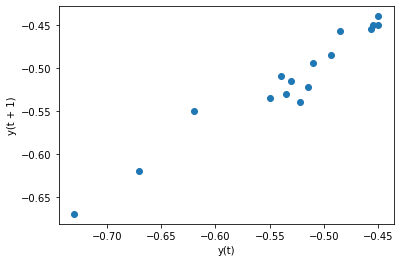

In [99]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
series = read_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', header=0, index_col=0)
lag_plot(series)
pyplot.show()

 some positive correlation, now let us numerically verify

In [89]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
series = read_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', header=0, index_col=0)
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)


      t-1   t+1
t-1 1.000 0.970
t+1 0.970 1.000


### Autoregressive model for out-of-sample predictions 
TODO: 1-step lookahead --> N-step lookahead



Coefficients: [-0.22681146  0.55951106]
predicted=-0.512162, expected=-0.494000
predicted=-0.513372, expected=-0.485000
predicted=-0.514049, expected=-0.456667
predicted=-0.514427, expected=-0.455000
predicted=-0.514639, expected=-0.450000
predicted=-0.514758, expected=-0.450000
predicted=-0.514824, expected=-0.440000
Test RMSE: 0.056


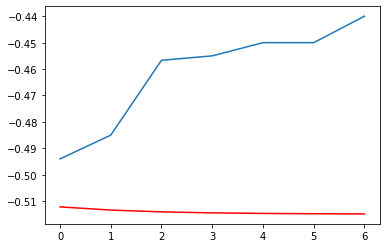

In [97]:
# static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
series = read_csv('/content/gdrive/MyDrive/Group 9 Project Documents/Datasets/cleaned_datasets/eri_univariate.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.reset_index(drop=True, inplace=True)

# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


from pandas import datetime
start_index = datetime(1990, 12, 25)
end_index = datetime(1990, 12, 26)
forecast = model_fit.predict(start=start_index, end=end_index)